In [2]:
import arviz as az

try:
    import bambi as bmb
except ModuleNotFoundError:
    %pip install bambi
    import bambi as bmb
import jax
import jax.numpy as jnp
import logging
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns
import tensorflow_probability.substrates.jax as tfp

from rmh import rmh_inference_loop,plot_rmh

tfd = tfp.distributions

logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

2022-06-23 14:08:29.866709: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [3]:
az.style.use("arviz-darkgrid")
key = jax.random.PRNGKey(1)

%load_ext autoreload
%autoreload 2

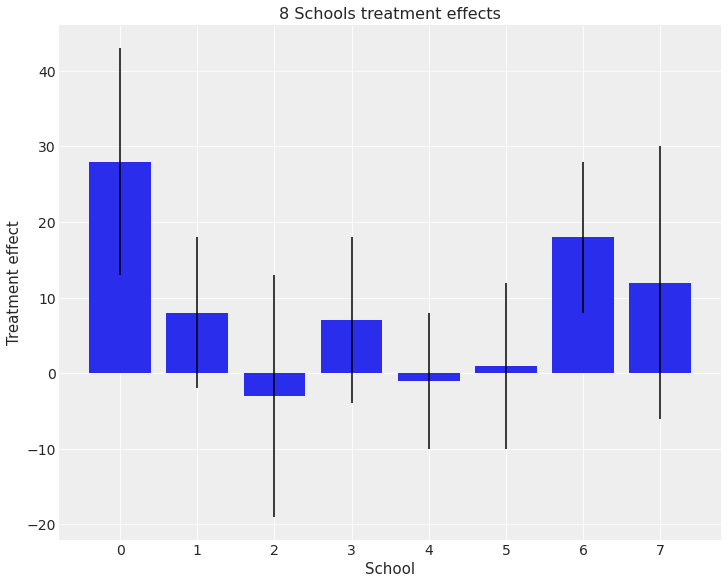

In [4]:
num_schools = 8  # number of schools
treatment_effects = jnp.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=jnp.float32)  # treatment effects
treatment_stddevs = jnp.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=jnp.float32)  # treatment SE

fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
fig.set_size_inches(10, 8)
plt.show()

# Multilevel Model

\begin{align*}
y_i = \text{treatment effects} \\
\sigma_i= \text{std dev treatement effects.} 
\end{align*}

These two are the observed variables. 

![8 schools](8_schools_model.png)

In [5]:
import arviz as az
import jax.numpy as jnp
import jax

def arviz_trace_from_states(states, info, burn_in=0):
    """
    args:
    ...........
    states: contains samples returned by blackjax model (i.e HMCState)
    info: conatins the meta info returned by blackjax model (i.e HMCinfo)
    
    returns:
    ...........
    trace: arviz trace object
    """
    if isinstance(states.position, jnp.DeviceArray):  #if states.position is array of samples 
        samples = {"samples":jnp.swapaxes(states.position,0,1)}
        divergence = jnp.swapaxes(info.is_divergent, 0, 1)
     
    else: # if states.position is dict 
        samples = {}        
        for param in states.position.keys():
            ndims = len(states.position[param].shape)
            if ndims >= 2:
                samples[param] = jnp.swapaxes(states.position[param], 0, 1)[:, burn_in:]  # swap n_samples and n_chains
                divergence = jnp.swapaxes(info.is_divergent[burn_in:], 0, 1)

            if ndims == 1:
                divergence = info.is_divergent
                samples[param] = states.position[param]
                
    trace_posterior = az.convert_to_inference_data(samples)
    trace_sample_stats = az.convert_to_inference_data({"diverging": divergence}, group="sample_stats")
    trace = az.concat(trace_posterior, trace_sample_stats)
    return trace

def inference_loop_multiple_chains(rng_key, kernel, initial_states, num_samples, num_chains):
    '''
    returns dict: {"states": states, "info": info}
    Visit this page for more info: https://blackjax-devs.github.io/blackjax/examples/Introduction.html
    '''
    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, infos = jax.vmap(kernel)(keys, states) 
        return states, (states, infos)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_states, keys)

    return (states, infos)

def inference_loop(rng_key, kernel, initial_state, num_samples):
    '''
    returns (states, info)
    Visit this page for more info: https://blackjax-devs.github.io/blackjax/examples/Introduction.html
    '''
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return (states, infos)

In [6]:
prior_mu = tfd.Normal(0,10)
prior_tou = tfd.LogNormal(5,1)


def log_post_fn(params):
    mu,tou,theta = params['mu'],params['tou'],params['theta']
    log_prior_mu = prior_mu.log_prob(mu)
    log_prior_tou = prior_tou.log_prob(tou)
    log_prior_theta = jnp.sum(tfd.Normal(mu,tou).log_prob(theta))
    log_like = 0
    log_like += jnp.sum(tfd.Normal(theta,treatment_stddevs).log_prob(treatment_effects))

    return log_like+log_prior_mu+log_prior_theta+log_prior_tou

params = {
    'mu' : 10.0,
    'tou': 15.0,
    'theta': jnp.ones(treatment_effects.shape[0])*1

}
log_post_fn(params)

DeviceArray(-71.45308, dtype=float32)

In [33]:
import blackjax
rng_key1 = jax.random.PRNGKey(0)
rng_key2,rng_key3 = jax.random.split(rng_key1)

num_chains = 3

nuts = blackjax.nuts(log_post_fn,step_size= 0.09,inverse_mass_matrix = jnp.ones(10)*1)

params_re = {
    'mu' : jax.random.uniform(key=rng_key1,shape=(num_chains,)),
    'tou': jax.random.uniform(key=rng_key2,shape=(num_chains,)),
    'theta': jax.random.uniform(key=rng_key3,shape=(num_chains,num_schools,)),
}

initial_states = jax.vmap(nuts.init)(params_re)
states_cent,info_cent = inference_loop_multiple_chains(rng_key1,kernel= nuts.step,initial_states= initial_states, num_samples=1500, num_chains=num_chains)

In [34]:
trace_centered = arviz_trace_from_states(states=states_cent,info=info_cent)
smry = az.summary(trace_centered)
smry

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5.791,5.636,-4.318,16.964,0.100,0.076,3161.0,2996.0,1.0
theta[0],14.974,10.494,-4.447,34.381,0.229,0.166,2135.0,2667.0,1.0
theta[1],7.149,8.216,-8.468,22.419,0.128,0.109,4110.0,3317.0,1.0
theta[2],2.540,10.729,-18.022,22.555,0.214,0.181,2540.0,2186.0,1.0
theta[3],6.562,8.293,-9.924,21.543,0.133,0.110,3855.0,2804.0,1.0
theta[4],1.891,7.341,-11.477,15.606,0.111,0.111,4324.0,3251.0,1.0
theta[5],3.403,8.685,-12.627,20.166,0.145,0.123,3640.0,3192.0,1.0
theta[6],12.970,8.170,-1.345,29.492,0.154,0.115,2863.0,2763.0,1.0
theta[7],8.251,11.029,-12.731,29.199,0.217,0.184,2618.0,2296.0,1.0
tou,13.170,6.765,2.929,25.474,0.197,0.139,1134.0,1685.0,1.0


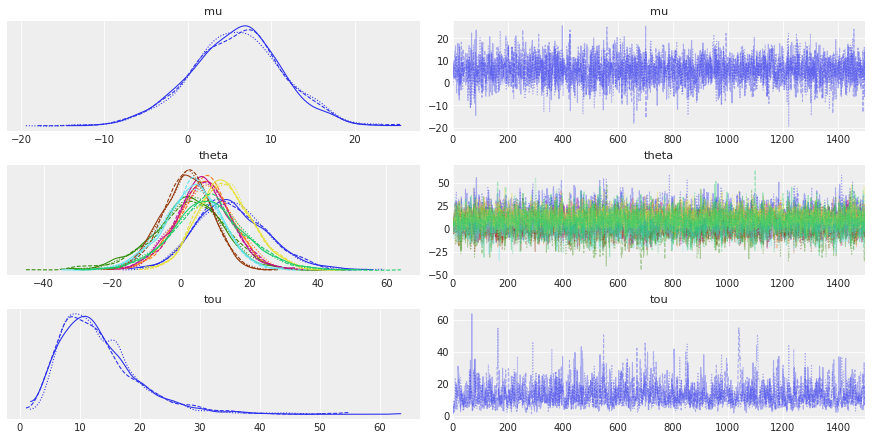

In [35]:
az.plot_trace(trace_centered);

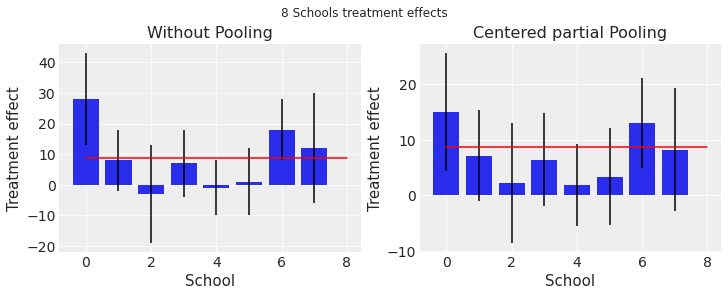

In [36]:
burnin =  300
# thetas = states.position['ita']*jnp.mean(states.position['tou'][burnin:])+jnp.mean(states.position['mu'][burnin:])
thetas_cent = states_cent.position['theta']
fig, (ax1,ax2)= plt.subplots(1,2,figsize=(10,4))
ax1.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
ax2.bar(range(num_schools), jnp.mean(jnp.mean(thetas_cent[burnin:,:],axis=0),axis=0),yerr=jnp.mean(jnp.std(thetas_cent[burnin:,:],axis=0),axis=0))
ax1.plot([0,8],[treatment_effects.mean(),treatment_effects.mean()],color='r',label='global mean')
ax2.plot([0,8],[treatment_effects.mean(),treatment_effects.mean()],color='r',label='global mean')
ax1.set_xlabel("School")
ax1.set_ylabel("Treatment effect")
ax1.set_title("Without Pooling")
ax2.set_title("Centered partial Pooling")
plt.suptitle("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
plt.show()


# With reparameterization

In [23]:
prior_mu = tfd.Normal(0,10)
prior_tou = tfd.LogNormal(5,1)


def log_post_fn_reparameterized(params):
    mu,tou,ita = params['mu'],params['tou'],params['ita']
    log_prior_mu = prior_mu.log_prob(mu)
    log_prior_tou = prior_tou.log_prob(tou)
    log_prior_theta = jnp.sum(tfd.Normal(0,1).log_prob(ita))
    log_like = 0
    # for i in range(treatment_effects.shape[0]):
    log_like += jnp.sum(tfd.Normal(mu+tou*ita,treatment_stddevs).log_prob(treatment_effects))
    # log_like += jnp.sum(tfd.Normal(0,1).log_prob((treatment_effects-theta)/treatment_stddevs))

    return log_like+log_prior_mu+log_prior_theta+log_prior_tou

params_re = {
    'mu' : 10.0,
    'tou': 15.0,
    'ita': jnp.ones(treatment_effects.shape[0])*1

}

log_post_fn_reparameterized(params_re)

DeviceArray(-60.041145, dtype=float32)

In [24]:
import blackjax
rng_key1 = jax.random.PRNGKey(0)
rng_key2,rng_key3 = jax.random.split(rng_key1)

num_chains = 8

# states = rmh_inference_loop(log_post_fn,jnp.ones(10)*2,params,40000)

nuts = blackjax.nuts(log_post_fn_reparameterized,step_size= 0.1,inverse_mass_matrix = jnp.ones(10)*0.5)
# initial_state = nuts.init(params_re)

params_re = {
    'mu' : jax.random.uniform(key=rng_key1,shape=(num_chains,)),
    'tou': jax.random.uniform(key=rng_key2,shape=(num_chains,)),
    'ita': jax.random.uniform(key=rng_key3,shape=(num_chains,num_schools,)),
    
}


initial_states = jax.vmap(nuts.init)(params_re)
states_non_cent,info_non_cent = inference_loop_multiple_chains(rng_key1,kernel= nuts.step,initial_states= initial_states, num_samples=1500, num_chains=num_chains)

In [25]:
trace_non_cent = arviz_trace_from_states(states=states_non_cent,info=info_non_cent)
smry = az.summary(trace_non_cent)
smry

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ita[0],0.647,0.811,-0.877,2.200,0.008,0.007,10516.0,7026.0,1.00
ita[1],0.110,0.720,-1.191,1.544,0.008,0.008,8928.0,6832.0,1.00
ita[2],-0.227,0.801,-1.761,1.229,0.007,0.008,11677.0,8022.0,1.00
ita[3],0.043,0.734,-1.389,1.443,0.008,0.008,8586.0,7348.0,1.00
ita[4],-0.337,0.690,-1.662,0.970,0.008,0.007,7123.0,7573.0,1.00
ita[5],-0.197,0.732,-1.577,1.189,0.008,0.008,8898.0,7376.0,1.00
ita[6],0.548,0.710,-0.762,1.974,0.008,0.007,8263.0,7456.0,1.00
ita[7],0.142,0.839,-1.488,1.681,0.008,0.008,11562.0,7960.0,1.00
mu,5.691,5.411,-4.573,15.567,0.147,0.104,1357.0,1442.0,1.01
tou,12.520,6.349,2.831,24.099,0.211,0.151,991.0,1296.0,1.01


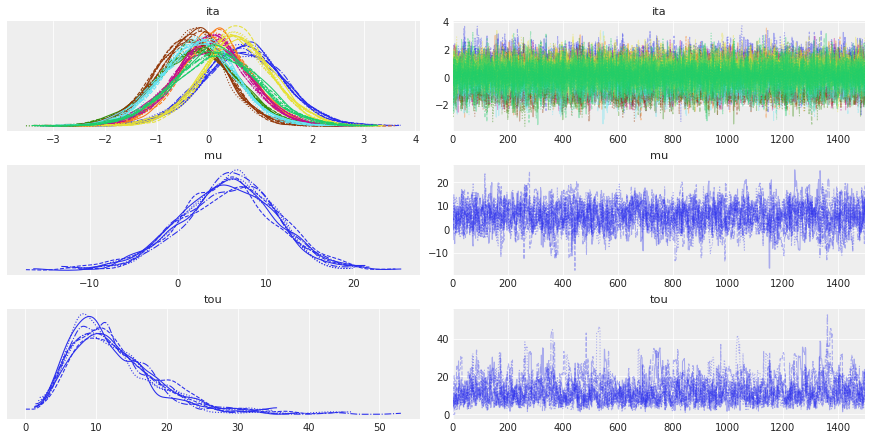

In [26]:
az.plot_trace(trace_non_cent);

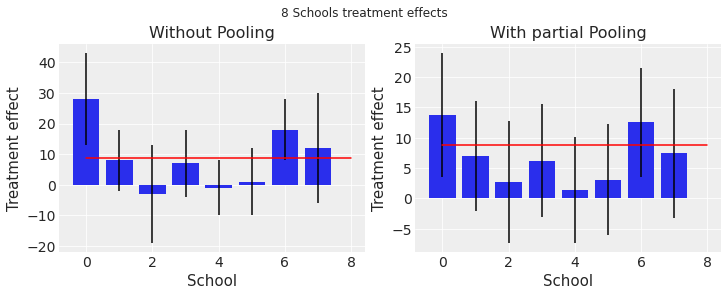

In [125]:
burnin =  300
thetas = states_non_cent.position['ita']*jnp.mean(states_non_cent.position['tou'][burnin:])+jnp.mean(states_non_cent.position['mu'][burnin:])
fig, (ax1,ax2)= plt.subplots(1,2,figsize=(10,4))
ax1.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
ax2.bar(range(num_schools), jnp.mean(jnp.mean(thetas[burnin:,:],axis=0),axis=0),yerr=jnp.mean(jnp.std(thetas[burnin:,:],axis=0),axis=0))
ax1.plot([0,8],[treatment_effects.mean(),treatment_effects.mean()],color='r',label='global mean')
ax2.plot([0,8],[treatment_effects.mean(),treatment_effects.mean()],color='r',label='global mean')
ax1.set_xlabel("School")
ax1.set_ylabel("Treatment effect")
ax1.set_title("Without Pooling")
ax2.set_title("Non Centerd partial Pooling ")
plt.suptitle("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
plt.show()


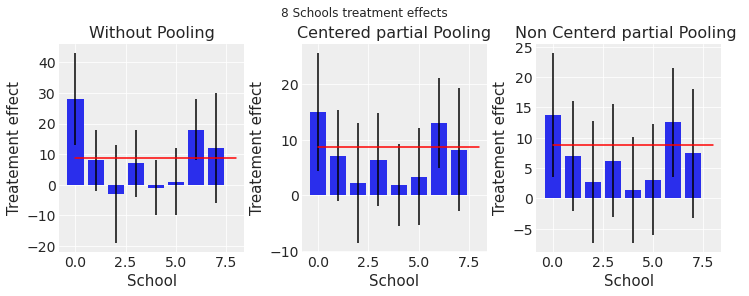

In [37]:
burnin =  300
thetas_non_cent = states_non_cent.position['ita']*jnp.mean(states_non_cent.position['tou'][burnin:])+jnp.mean(states_non_cent.position['mu'][burnin:])
fig, ax= plt.subplots(1,3,figsize=(10,4))
ax[0].bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
ax[2].bar(range(num_schools), jnp.mean(jnp.mean(thetas_non_cent[burnin:,:],axis=0),axis=0),yerr=jnp.mean(jnp.std(thetas_non_cent[burnin:,:],axis=0),axis=0))
ax[1].bar(range(num_schools), jnp.mean(jnp.mean(thetas_cent[burnin:,:],axis=0),axis=0),yerr=jnp.mean(jnp.std(thetas_cent[burnin:,:],axis=0),axis=0))
for i in range(3):
    ax[i].plot([0,8],[treatment_effects.mean(),treatment_effects.mean()],color='r',label='global mean')
    ax[i].set_xlabel('School')
    ax[i].set_ylabel('Treatement effect')

ax[0].set_title("Without Pooling")
ax[2].set_title("Non Centerd partial Pooling ")
ax[1].set_title("Centered partial Pooling")

plt.suptitle("8 Schools treatment effects")

plt.show()


Inference data with groups:
	> posterior
	> sample_stats

In [38]:
trace_non_cent_df = trace_non_cent.to_dataframe()

In [39]:
trace_cent_df = trace_centered.to_dataframe()

In [40]:
col_names_cent = []
for i in trace_cent_df.columns:
    if(len(i)==3  ):
        col_names_cent.append(i[1])
    else:
        col_names_cent.append(i)
col_names_cent[2] = 'mu'
col_names_cent[-2] = 'tou'
col_names_cent

['chain',
 'draw',
 'mu',
 'theta[0]',
 'theta[1]',
 'theta[2]',
 'theta[3]',
 'theta[4]',
 'theta[5]',
 'theta[6]',
 'theta[7]',
 'tou',
 ('sample_stats', 'diverging')]

In [41]:
trace_cent_df.columns = col_names_cent

In [42]:
trace_non_cent_df

,chain,draw,"(posterior, ita[0], 0)","(posterior, ita[1], 1)","(posterior, ita[2], 2)","(posterior, ita[3], 3)","(posterior, ita[4], 4)","(posterior, ita[5], 5)","(posterior, ita[6], 6)","(posterior, ita[7], 7)","(posterior, mu)","(posterior, tou)","(sample_stats, diverging)"
0,0,0,0.242017,1.598430,0.285350,-1.089840,0.254288,0.308065,0.168111,-0.332370,1.119790,4.846406,False
1,0,1,0.822883,0.667317,0.257920,0.441605,0.943675,-0.604932,0.348982,-0.419952,0.791754,4.663679,False
2,0,2,0.246035,0.087337,0.125893,0.110704,-1.274410,-0.061416,1.126004,-0.129231,1.600590,6.212002,False
3,0,3,1.483438,0.723012,0.218980,0.901003,0.077957,1.345398,-0.896561,-1.313332,2.058394,7.286953,False
4,0,4,1.264437,0.489617,0.426540,0.631801,-0.163651,1.948596,-1.284711,-2.535152,2.108179,7.288484,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,7,1495,0.530428,0.998438,-1.175500,-0.125221,-0.547745,-0.911868,0.644124,0.702145,12.256798,14.586588,False
11996,7,1496,0.291761,-1.452270,0.453472,-0.423353,-0.389100,-0.166773,-0.206622,-0.888610,13.645112,12.960270,False
11997,7,1497,1.279167,-0.231344,-0.779377,-0.026619,-0.965831,-0.759035,0.091232,0.509626,13.873395,14.065439,False
11998,7,1498,0.855538,0.047901,-0.531548,-0.529758,-0.686729,0.148209,0.670679,1.070391,6.108712,11.716146,False


In [49]:
col_names_non_cent = []
for i in trace_non_cent_df.columns:
    if(len(i)==3):
        col_names_non_cent.append(i[1])
    else:
        col_names_non_cent.append(i)
col_names_non_cent[-3] = 'mu'
col_names_non_cent[-2] = 'tou'

In [45]:
trace_non_cent_df.columns = col_names_non_cent

In [46]:
for i in range(8):
    trace_non_cent_df['theta['+str(i)+']'] = trace_non_cent_df['ita['+str(i)+']']*trace_non_cent_df['tou']+trace_non_cent_df['mu']

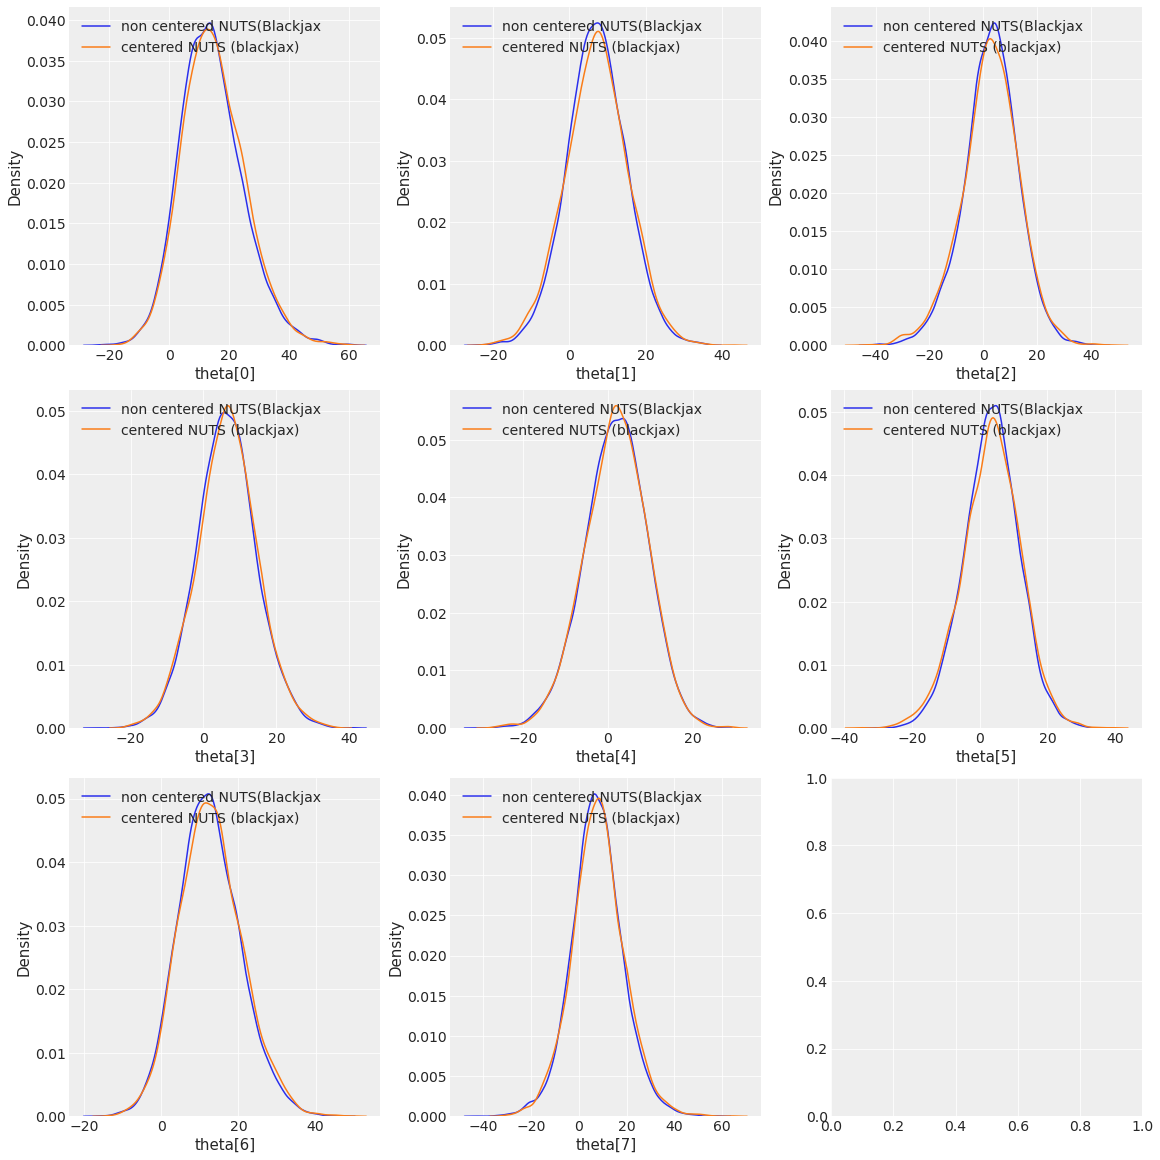

In [48]:
fig,ax = plt.subplots(3,3,figsize=(16,16))

for i in range(8):
    sns.kdeplot(trace_non_cent_df['theta['+str(i)+']'],label=f"non centered NUTS(Blackjax)" ,ax=ax[int(i/3)][i%3])
    sns.kdeplot(trace_cent_df['theta['+str(i)+']'],label=f"centered NUTS (blackjax)" ,ax=ax[int(i/3)][i%3])

    ax[int(i/3)][i%3].legend(loc=2)


In [182]:
trace_non_cent_df.to_pickle("../../results/8_schools/results_data/blackjax_non_cent.pkl")
trace_cent_df.to_pickle("../../results/8_schools/results_data/blackjax_cent.pkl")